In [3]:
import boto3
import pandas as pd
from sagemaker import get_execution_role

role = get_execution_role()
bucket='sagemaker-nomadiq-data'
data_key = 'instagram_df.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

df = pd.read_csv(data_location)

In [4]:
%matplotlib inline

import json
import os
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import re
from datetime import datetime


# EDA

Text(0.5,1,'Most Popular Travel Destinations')

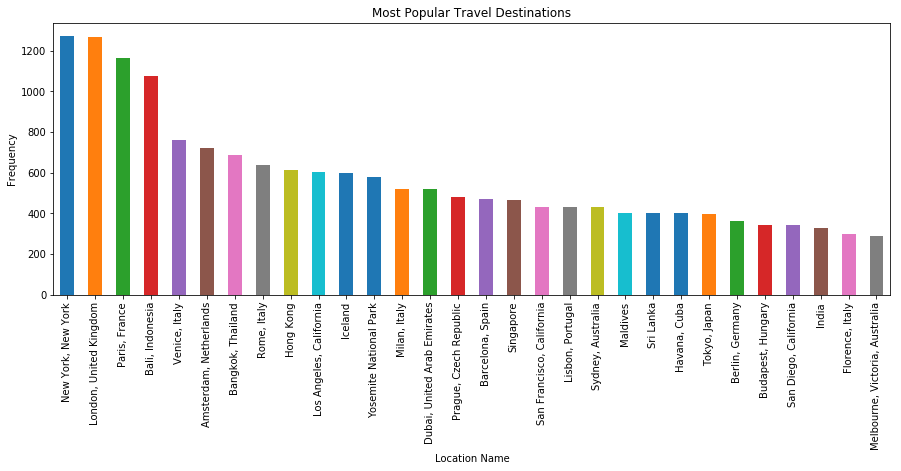

In [5]:
fig, ax = plt.subplots(figsize = (15,5))

df.location_name.value_counts()[:30].plot(kind = "bar")
ax.set_xlabel("Location Name")
ax.set_ylabel("Frequency")
ax.set_title("Most Popular Travel Destinations")

Text(0.5,1,'Posts by Month')

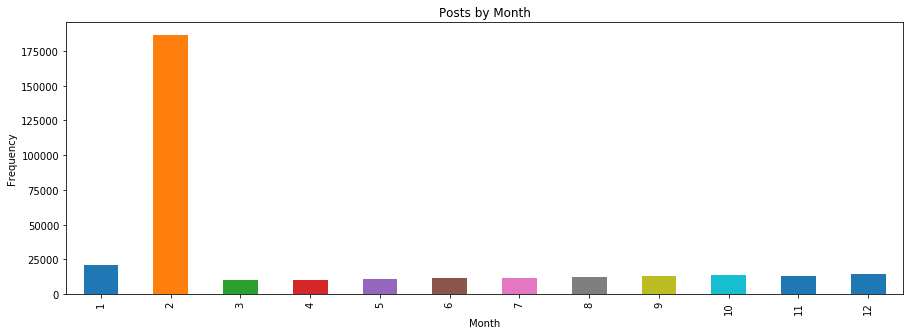

In [7]:
month_posts = df.month.value_counts()
month_posts.index = month_posts.index.map(int)
month_posts.sort_index()

fig, ax = plt.subplots(figsize = (15,5))

month_posts.sort_index().plot(kind = "bar",sort_columns=True)
ax.set_xlabel("Month")
ax.set_ylabel("Frequency")
ax.set_title("Posts by Month")